# 05. PyTorch Custom Datasets Exercises Template

Welcome to the 05. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Tue May 23 10:58:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.79                 Driver Version: 531.79       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090       WDDM | 00000000:01:00.0  On |                  Off |
|  0%   47C    P8               16W / 450W|   1221MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Adding more layers to the model.
2. Less regularization.
3. Run more epochs.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [4]:
# 1. Get data
import requests
from pathlib import Path
import zipfile

DATA_URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"

data_path = Path("data/")
image_path= data_path / "pizza_sushi_steak"

#if the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print("Image directory already exist, skipping download...")
else: 
    print(f"{image_path} doesn't exist, creating one...")
    
# Downloading data
with open(data_path/"pizza_sushi_steak.zip", "wb") as f:
    request = requests.get(DATA_URL)
    print(f"Downloading pizza, steak and sushi data...")
    f.write(request.content)
    
# Unzip data
with zipfile.ZipFile(data_path/"pizza_sushi_steak.zip", 'r') as zip_ref:
    print("Unzipping data file")
    zip_ref.extractall(image_path)

Image directory already exist, skipping download...
Unzipping data file


In [5]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_sushi_steak'.
There are 3 directories and 0 images in 'data\pizza_sushi_steak\test'.
There are 0 directories and 25 images in 'data\pizza_sushi_steak\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_sushi_steak\test\steak'.
There are 0 directories and 31 images in 'data\pizza_sushi_steak\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_sushi_steak\train'.
There are 0 directories and 78 images in 'data\pizza_sushi_steak\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_sushi_steak\train\steak'.
There are 0 directories and 72 images in 'data\pizza_sushi_steak\train\sushi'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

data\pizza_sushi_steak\test\pizza\1152100.jpg
image height: 512


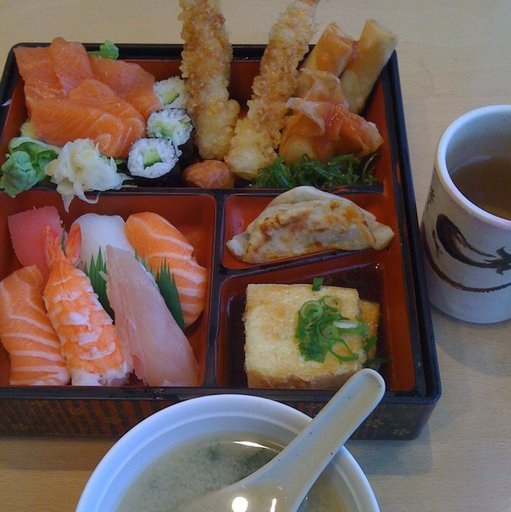

In [26]:
# Visualize an image
import matplotlib.pyplot as plt
from PIL import Image
import random

# Image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
print(image_path_list[0])

# Randomly selected path
random_image_path = random.choice(image_path_list)

# Visualizing
img = Image.open(random_image_path)
print(f"image height: {img.height}")
img

(-0.5, 510.5, 511.5, -0.5)

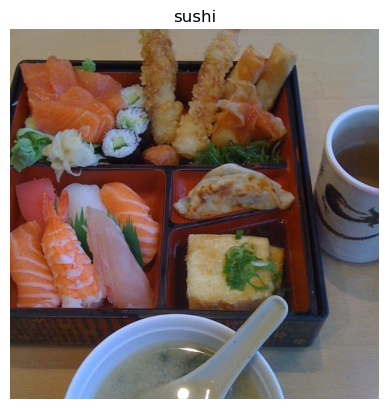

In [32]:
# Do the image visualization with matplotlib
plt.imshow(img)
plt.title(random_image_path.parent.stem)
plt.axis(False)

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

# 3.1 Transforming data with torchvision.transforms


In [37]:
# Write transform for turning images into tensors
import torchvision
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

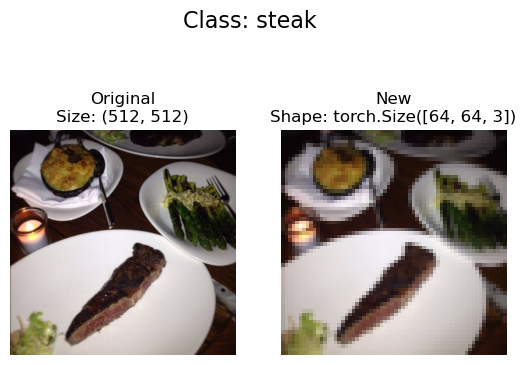

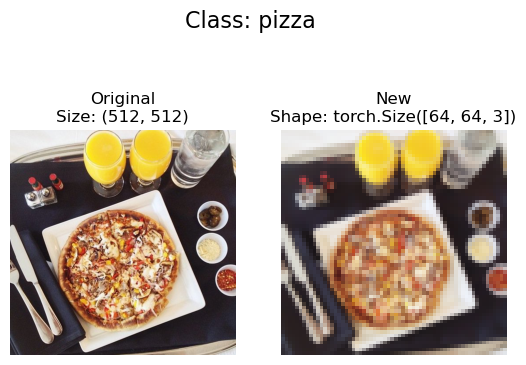

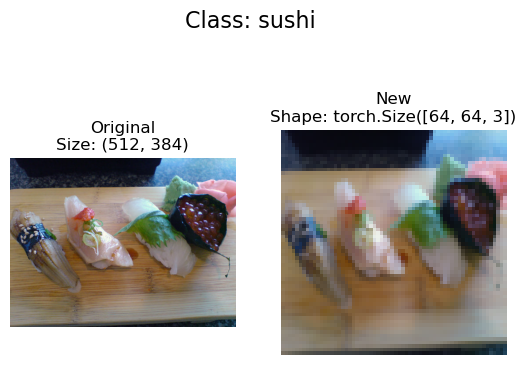

In [42]:
# Write a function to plot transformed images
def plot_transformed_image(transformer: torchvision.transforms,
                          image_paths: list,
                          n=3,
                          seed=None):
    if seed:
        random.seed(seed)
    random_images = random.sample(image_paths, k=n)
    for image_path in random_images:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            transformed_image = transformer(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"New\nShape: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

                
plot_transformed_image(transformer=transform, image_paths=image_path_list, n=3)

### Load image data using `ImageFolder`

In [43]:
# Use ImageFolder to create dataset(s)
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                        transform=transform,
                        target_transform=None)

test_data = ImageFolder(root=test_dir,
                       transform=transform)

In [44]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [45]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [46]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [48]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_data,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=NUM_WORKERS)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x20de9e36e50>,
 <torch.utils.data.dataloader.DataLoader at 0x20de9e36370>)

In [50]:
# How many batches of images are in our data loaders?
len(train_dataloader)

8

## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [71]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape: int,
                hidden_layer: int,
                output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                     out_channels=hidden_layer,
                     kernel_size=3,
                     padding=0,
                     stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer,
                     out_channels=hidden_layer,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layer,
                     out_channels=hidden_layer,
                     kernel_size=3,
                     padding=0,
                     stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_layer,
                     out_channels=hidden_layer,
                     kernel_size=3,
                     stride=1,
                     padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layer*13*13,
                     out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))
    
    
model_0 = TinyVGG(input_shape=3,
                 hidden_layer=10,
                 output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

## 4. Create training and testing functions for `model_0`.

In [64]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
    # Put the model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader and data batches
    for batch, (X, y) in enumerate(dataloader):
 
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)
        
        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

        # 3. Optimizer zero grad 
        optimizer.zero_grad()

        # 4. Loss backward 
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumualte accuracy metric across all batches
        train_loss += loss.item()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and average accuracy per batch
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

In [65]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
    # Put model in eval mode
    model.eval()

    # Setup the test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for X, y in dataloader:
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculuate and accumulate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            y_pred_classes = torch.argmax(torch.softmax(y_pred, dim=1),dim=1)
            test_acc += (y_pred_classes==y).sum().item() / len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    test_acc /= len(dataloader)
    test_loss /= len(dataloader)
    return test_loss, test_acc

In [66]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
    # Create results dictionary
    results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

    # Loop through the training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        # Train step
        train_loss, train_acc = train_step(model=model, 
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        # Test step
        test_loss, test_acc = test_step(model=model, 
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f}% | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}%"
        )

        # Update the results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the results dictionary
    return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [67]:
from timeit import default_timer as timer

# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

start = timer()

model_0_5_epoch_result = train(model=model_0, 
                              train_dataloader=train_dataloader, 
                              test_dataloader=test_dataloader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              epochs=5)

end = timer()
print(f"Total Time Taken: {end-start:.3f}seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1019 | train_acc: 0.2500% | test_loss: 1.0947 | test_acc: 0.2604%
Epoch: 2 | train_loss: 1.0843 | train_acc: 0.4258% | test_loss: 1.1068 | test_acc: 0.2604%
Epoch: 3 | train_loss: 1.0744 | train_acc: 0.4258% | test_loss: 1.1364 | test_acc: 0.2604%
Epoch: 4 | train_loss: 1.1225 | train_acc: 0.3047% | test_loss: 1.1447 | test_acc: 0.2604%
Epoch: 5 | train_loss: 1.0807 | train_acc: 0.4258% | test_loss: 1.1309 | test_acc: 0.2604%
Total Time Taken: 12.389seconds


In [70]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

start = timer()

model_0_20_epochs = train(model=model_0,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         epochs=20)

end = timer()
print(f"Total time taken: {end-start: .3f}seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1005 | train_acc: 0.2500% | test_loss: 1.0969 | test_acc: 0.2604%
Epoch: 2 | train_loss: 1.0915 | train_acc: 0.4258% | test_loss: 1.1009 | test_acc: 0.2604%
Epoch: 3 | train_loss: 1.0815 | train_acc: 0.4258% | test_loss: 1.1092 | test_acc: 0.2604%
Epoch: 4 | train_loss: 1.1117 | train_acc: 0.3047% | test_loss: 1.1175 | test_acc: 0.2604%
Epoch: 5 | train_loss: 1.0625 | train_acc: 0.4258% | test_loss: 1.1261 | test_acc: 0.2604%
Epoch: 6 | train_loss: 1.1202 | train_acc: 0.3047% | test_loss: 1.1331 | test_acc: 0.2604%
Epoch: 7 | train_loss: 1.0628 | train_acc: 0.4844% | test_loss: 1.1159 | test_acc: 0.2188%
Epoch: 8 | train_loss: 1.0941 | train_acc: 0.3750% | test_loss: 1.1242 | test_acc: 0.2604%
Epoch: 9 | train_loss: 1.1025 | train_acc: 0.3906% | test_loss: 1.1401 | test_acc: 0.2812%
Epoch: 10 | train_loss: 1.0131 | train_acc: 0.5312% | test_loss: 1.0840 | test_acc: 0.3722%
Epoch: 11 | train_loss: 1.0042 | train_acc: 0.6055% | test_loss: 1.0659 | test_acc: 0.402

In [72]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), 
                             lr=0.001)

start = timer()

model_0_50_epochs = train(model=model_0,
                         train_dataloader=train_dataloader,
                         test_dataloader=test_dataloader,
                         loss_fn=loss_fn,
                         optimizer=optimizer,
                         epochs=50)

end = timer()
print(f"Total time taken: {end-start: .3f}seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1005 | train_acc: 0.2500% | test_loss: 1.0969 | test_acc: 0.2604%
Epoch: 2 | train_loss: 1.0915 | train_acc: 0.4258% | test_loss: 1.1009 | test_acc: 0.2604%
Epoch: 3 | train_loss: 1.0815 | train_acc: 0.4258% | test_loss: 1.1092 | test_acc: 0.2604%
Epoch: 4 | train_loss: 1.1117 | train_acc: 0.3047% | test_loss: 1.1175 | test_acc: 0.2604%
Epoch: 5 | train_loss: 1.0625 | train_acc: 0.4258% | test_loss: 1.1261 | test_acc: 0.2604%
Epoch: 6 | train_loss: 1.1200 | train_acc: 0.3047% | test_loss: 1.1332 | test_acc: 0.2604%
Epoch: 7 | train_loss: 1.0629 | train_acc: 0.4844% | test_loss: 1.1161 | test_acc: 0.2188%
Epoch: 8 | train_loss: 1.0944 | train_acc: 0.3750% | test_loss: 1.1246 | test_acc: 0.2604%
Epoch: 9 | train_loss: 1.1024 | train_acc: 0.3945% | test_loss: 1.1410 | test_acc: 0.2812%
Epoch: 10 | train_loss: 1.0129 | train_acc: 0.5312% | test_loss: 1.0833 | test_acc: 0.3513%
Epoch: 11 | train_loss: 1.0042 | train_acc: 0.6094% | test_loss: 1.0670 | test_acc: 0.381

It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [76]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                 hidden_layer=20,
                 output_shape=len(class_names)).to(device)

model_1_doubled_layer_result = train(model=model_1,
                                    train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    optimizer=optimizer,
                                    epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0958 | train_acc: 0.4141% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 2 | train_loss: 1.1008 | train_acc: 0.2930% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 3 | train_loss: 1.1010 | train_acc: 0.2930% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 4 | train_loss: 1.0954 | train_acc: 0.4141% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 5 | train_loss: 1.0954 | train_acc: 0.4141% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 6 | train_loss: 1.0956 | train_acc: 0.4141% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 7 | train_loss: 1.1012 | train_acc: 0.2930% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 8 | train_loss: 1.0956 | train_acc: 0.4141% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 9 | train_loss: 1.1014 | train_acc: 0.2930% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 10 | train_loss: 1.1001 | train_acc: 0.2930% | test_loss: 1.1045 | test_acc: 0.1979%
Epoch: 11 | train_loss: 1.1006 | train_acc: 0.2930% | test_loss: 1.1045 | test_acc: 0.197

It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [77]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [78]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [ ]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

In [ ]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

# Create datasets


# Create dataloaders


In [ ]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?